In [1]:
%pylab inline
import emcee
import programas as pg
import h5py
import MAS_library as MASL
import smoothing_library as SL

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Función de verosimilitud
def log_likelihood(params, F_obs, F0, F1, F2, F3,F4, C_inv):
    b1, b2, b3,b4 = params
    model = F0 + b1 * F1 + b2 * F2 + b3 * F3 + b4*F4 - 1
    diff = F_obs - model
    return -0.5 * np.dot(diff, np.dot(C_inv, diff))

# Priors
def log_prior(params):
    b1, b2, b3, b4 = params
    if -20 < b1 < 20 and -20 < b2 < 20 and -20 < b3 < 20 and -50 < b4 < 50:  # Rango de ejemplo
        return 0.0
    return -np.inf

# Función posterior
def log_posterior(params, F_obs, F0, F1, F2,F3, F4, C_inv):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, F_obs, F0, F1, F2, F3,F4, C_inv)

def covariance_mat(pmean, pall):
    
    njack  = pall.shape[0]
    nbines = pall.shape[1]
    C = np.zeros([nbines,nbines])
    
    for i in range(nbines):
        dif_pi = pall[:,i] - pmean[i]
        
        for j in range(nbines):
            dif_pj = pall[:,j] - pmean[j]
            
            C[i,j] = np.sum(dif_pi*dif_pj)
            
    C = ((njack-1)/njack)*C        
    return C

In [3]:
def perfil_jack(perfiles,realizaciones):
    # calcula el perfil con error jacknife y matriz
    # de covarianza 
    voidnumber = perfiles.shape[0]
    voidbines = perfiles.shape[1]
    ndivision = int(voidnumber/realizaciones)

    perfiles_jack = np.zeros([realizaciones,voidbines])
    
    total_ids = np.arange(0,voidnumber)

    exclude0 = 0
    for i in range(realizaciones):
        exclude1 = exclude0 + ndivision
    
    # selecciono (excluyo) los indices para hacer el jacknife
        selection = total_ids[(total_ids < exclude0) | (total_ids > exclude1)]
        perfiles_jack[i,:] = pg.mean_profile(perfiles[selection,:].T)
        
        exclude0 = exclude1
        
    perfiles_mean = np.zeros(voidbines)
    perfiles_error = np.zeros(voidbines)

    n = realizaciones
    for i in range(voidbines):
        media = np.mean(perfiles_jack[:,i])
        error = np.sqrt(((n-1)/n) * np.sum((perfiles_jack[:,i]-media)**2))
    
        perfiles_mean[i]  = media
        perfiles_error[i] = error
        
    return perfiles_mean, perfiles_error, perfiles_jack

In [20]:
rmin = 16
smooth = 18
damping_scale = 0.75

path = '/home/arodriguez/BACCO/bias-voids/IATE/perfiles/4f/'
#path = '/home/arodriguez/BACCO/bias-voids/IATE/voids-Pylians/'
f0_file = np.load(path+'perfiles_F0_'+str(smooth)+'_radio_'+str(rmin)+'_100bines_30.npy')
f1_file = np.load(path+'perfiles_F1_'+str(smooth)+'_radio_'+str(rmin)+'_100bines_30.npy')
f2_file = np.load(path+'perfiles_F2_'+str(smooth)+'_radio_'+str(rmin)+'_100bines_30.npy')
f3_file = np.load(path+'perfiles_F3_'+str(smooth)+'_radio_'+str(rmin)+'_100bines_30.npy')
f4_file = np.load(path+'perfiles_F4_'+str(smooth)+'_radio_'+str(rmin)+'_100bines_30.npy')


f0 = f0_file[:,1:]
f1 = f1_file[:,1:]
f2 = f2_file[:,1:]
f3 = f3_file[:,1:]
f4 = f4_file[:,1:]

realizaciones = 80

mean_0, error_0 = pg.perfil_jack(f0,realizaciones)
mean_1, error_1 = pg.perfil_jack(f1,realizaciones)
mean_2, error_2 = pg.perfil_jack(f2,realizaciones)
mean_3, error_3 = pg.perfil_jack(f3,realizaciones)
mean_4, error_4 = pg.perfil_jack(f4,realizaciones)

original = np.load(path+'perfiles_simulation_smooth_'+str(smooth)+'_radio_'+str(rmin)+'_100bines_30.npy')

obs = original[:,1:]
mean_obs, error_obs = pg.perfil_jack(obs,realizaciones)

In [119]:
f0.shape

(291, 30)

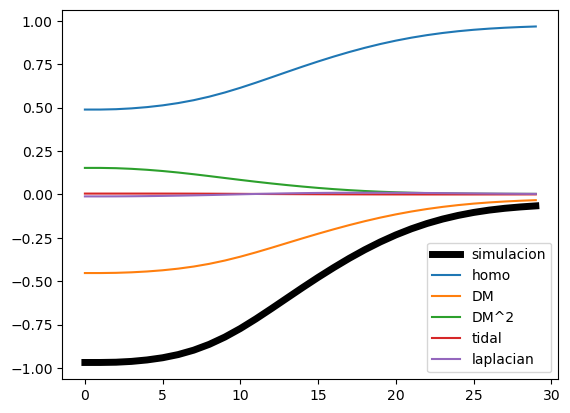

In [21]:
plt.plot(mean_obs, label='simulacion', color='black', lw=5)
plt.plot(mean_0, label='homo')
plt.plot(mean_1, label='DM')
plt.plot(mean_2, label='DM^2')
plt.plot(mean_3, label='tidal')
plt.plot(mean_4, label='laplacian')
plt.legend()


In [22]:
# IMPORTANTE: numero de jacknife tiene que ser mayor que el numero de bines (sino no puede invertirse)
#realizaciones = 80
mean_obs, error_obs, all_obs = perfil_jack(obs,realizaciones)

In [23]:
mean_obs.shape

(30,)

In [24]:
all_obs.shape

(80, 30)

In [25]:
C = covariance_mat(mean_obs,all_obs)

# normalization:
ies = C.shape[0]
jes = C.shape[1]

C_new = np.zeros([ies,jes])

for i in range(ies):
    for j in range(jes):
        
        C_new[i,j] = C[i,j]/np.sqrt(C[i,i]*C[j,j])
        
#C = C_new

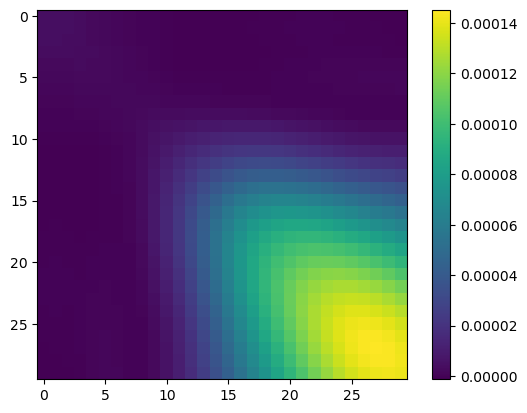

In [26]:
C = covariance_mat(mean_obs,all_obs)
C_diag = np.diag(np.diag(C))
plt.imshow(C)
plt.colorbar()

In [11]:
num_bines = mean_obs.shape[0]
njack = realizaciones
factor_h = 1 - (num_bines+1)/(njack-1)

In [12]:
F_obs = mean_obs
F0 = mean_0
F1 = mean_1
F2 = mean_2
F3 = mean_3
F4 = mean_4


# Inverso de la matriz de covarianza
#C_inv = np.linalg.inv(C)
C_inv = factor_h*np.linalg.inv(C)


# Configuración de MCMC
ndim = 4  # Número de parámetros
nwalkers = 50  # Número de walkers
nsteps = 10000  # Número de pasos

# Inicializar walkers aleatoriamente
starting_guesses = np.random.rand(nwalkers, ndim)

# Ejecutar MCMC
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(F_obs, F0, F1, F2,F3, F4, C_inv))
_ = sampler.run_mcmc(starting_guesses, nsteps, progress=True)

# Análisis de resultados
samples = sampler.get_chain(discard=500, thin=10, flat=True)  # Descartar los primeros 100 pasos (burn-in)
b1_samples, b2_samples, b3_samples, b4_samples = samples[:, 0], samples[:, 1], samples[:,2], samples[:,3]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:14<00:00, 712.41it/s]


In [13]:
b1_jens = 1.133331    
b2_jens = 0.54724399 
b3_jens = -0.37554869 
b4_jens = -1.18640415

#b1_jens = 1.04
#b2_jens = 0.24
#b4_jens = -2.45

#b1_jens = 0.99
#b2_jens = 0.04
#b4_jens = -5.56

In [14]:
f0_file.shape

(4110, 31)

In [15]:
dist = np.linspace(0,3,f0_file.shape[1]-1)

b1_mean, b1_std = np.mean(b1_samples), np.std(b1_samples)
b2_mean, b2_std = np.mean(b2_samples), np.std(b2_samples)
b3_mean, b3_std = np.mean(b3_samples), np.std(b3_samples)
b4_mean, b4_std = np.mean(b4_samples), np.std(b4_samples)

Text(0, 0.5, '$ \\delta_g(r) $')

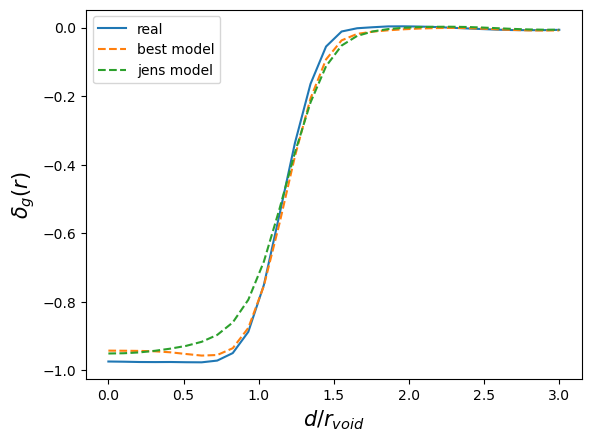

In [16]:
plt.plot(dist, F_obs, label='real')
plt.plot(dist, F0 + b1_mean*F1 + b2_mean*F2 + b3_mean*F3 + b4_mean*F4 - 1, ls='dashed', label='best model')
plt.plot(dist, F0 + b1_jens*F1 + b2_jens*F2 + b4_jens*F4 - 1, ls='dashed', label='jens model')

#plt.plot(F1,label='F1')
#plt.plot(F2,label='F2')
plt.legend()
#plt.ylim(-1.4,0.2)
plt.xlabel('$ d/r_{void}$',size=15)
plt.ylabel('$ \\delta_g(r) $',size=15)

BACCO: 1.133331 0.54724399 -1.18640415
BACCO: 1.439079668058322 1.6576936033245255 1.215503442301199


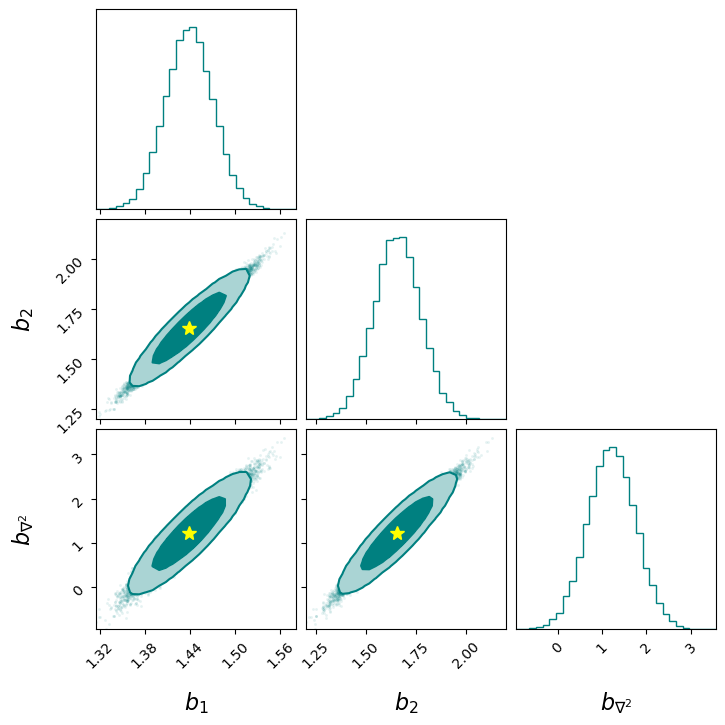

In [17]:
import corner
import random


seleccion = random.sample(list(np.arange(0,len(b1_samples))),30000)
# Crear el gráfico de corner con tres parámetros
figure = corner.corner(np.vstack([b1_samples[seleccion], b2_samples[seleccion], b4_samples[seleccion]]).T,
                       labels=["$ b_1 $", "$b_2$", "$ b_{\\nabla^2} $"],
                       bins=30, smooth=1.0, plot_datapoints=True,
                       plot_contours=True, fill_contours=True,
                       levels=[0.68, 0.95],
                       label_kwargs={"fontsize": 16},
                       color='teal')

# Obtener los ejes del corner plot
axes = figure.axes
# Agregar la estrellita en el panel correspondiente a (b1, b2)
axes[3].plot(b1_jens, b2_jens, marker='*', color='red', markersize=10)
axes[3].plot(b1_mean, b2_mean, marker='*', color='yellow', markersize=10)
# Agregar la estrellita en el panel correspondiente a (b1, b4)
axes[6].plot(b1_jens, b4_jens, marker='*', color='red', markersize=10)
axes[6].plot(b1_mean, b4_mean, marker='*', color='yellow', markersize=10)
# Agregar la estrellita en el panel correspondiente a (b2, b4)
axes[7].plot(b2_jens, b4_jens, marker='*', color='red', markersize=10)
axes[7].plot(b2_mean, b4_mean, marker='*', color='yellow', markersize=10)

print('BACCO:',b1_jens, b2_jens, b4_jens)
print('BACCO:',b1_mean, b2_mean, b4_mean)

In [18]:
import corner
import random


#seleccion = random.sample(list(np.arange(0,len(b1_samples))),30000)
# Crear el gráfico de corner con tres parámetros
figure = corner.corner(np.vstack([b1_samples, b2_samples, b3_samples ,b4_samples]).T,
                       labels=["$ b_1 $", "$b_2$", "$b_s$","$ b_{\\nabla^2} $"],
                       bins=30, smooth=1.0, plot_datapoints=True,
                       plot_contours=True, fill_contours=True,
                       levels=[0.68, 0.95],
                       label_kwargs={"fontsize": 16},
                       color='teal')

# Obtener los ejes del corner plot
axes = figure.axes
# Agregar la estrellita en el panel correspondiente a (b1, b2)
axes[4].plot(b1_jens, b2_jens, marker='*', color='red', markersize=10)
axes[4].plot(b1_mean, b2_mean, marker='*', color='yellow', markersize=10)
# Agregar la estrellita en el panel correspondiente a (b1, b4)
axes[8].plot(b1_jens, b4_jens, marker='*', color='red', markersize=10)
axes[8].plot(b1_mean, b4_mean, marker='*', color='yellow', markersize=10)
# Agregar la estrellita en el panel correspondiente a (b2, b4)
axes[12].plot(b2_jens, b4_jens, marker='*', color='red', markersize=10)
axes[12].plot(b2_mean, b4_mean, marker='*', color='yellow', markersize=10)

print('BACCO:',b1_jens, b2_jens, b4_jens)
print('BACCO:',b1_mean, b2_mean, b4_mean)

BACCO: 1.133331 0.54724399 -1.18640415
BACCO: 1.439079668058322 1.6576936033245255 1.215503442301199


In [134]:
pwd

'/home/arodriguez/BACCO/bias-voids/IATE'

In [135]:
path_par = '/home/arodriguez/BACCO/bias-voids/IATE/parameters_results/'
# Crear un archivo HDF5
with h5py.File(path_par+'parameters_rmin='+str(rmin)+'_k'+str(damping_scale)+'_4.h5', 'w') as hdf:
    # Crear datasets (columnas) en el archivo
    hdf.create_dataset('b1_samples', data=b1_samples)
    hdf.create_dataset('b2_samples', data=b2_samples)
    hdf.create_dataset('b3_samples', data=b3_samples)
    hdf.create_dataset('b4_samples', data=b4_samples)

Text(0.5, 0, '$ d/r_{void}$')

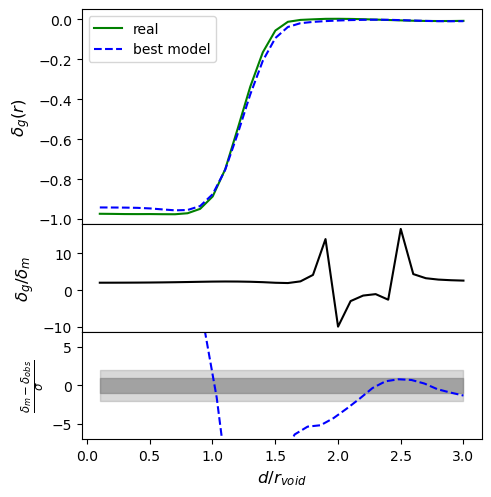

In [19]:
modelo = f0 + b1_mean*f1 + b2_mean*f2 + b3_mean*f3 + b4_mean*f4 - 1
modelo_jens = f0 + b1_jens*f1 + b2_jens*f2 + b4_jens*f4 - 1

dif_model, dif_model_e = pg.perfil_jack(modelo[:,1:]-obs[:,1:],realizaciones)
dif_modelj, dif_modelj_e = pg.perfil_jack(modelo_jens[:,1:]-obs[:,1:],realizaciones)

fig, ax = plt.subplots(ncols=1,nrows=3,figsize=(5,5),sharey='row'
                       ,gridspec_kw={'height_ratios': [2, 1, 1]})
fig.subplots_adjust(hspace=(0.00),wspace=(.28),bottom=0.12, top=0.98, left=0.17, right=0.97)

F_model_j = F0 + b1_jens*F1 + b2_jens*F2 + b4_jens*F4 - 1
F_model_m = F0 + b1_mean*F1 + b2_mean*F2 + b3_mean*F3 + b4_mean*F4 - 1

ax[0].plot(dist, F_obs, label='real', color='green')
ax[0].plot(dist, F_model_m, ls='dashed', label='best model', color='blue')
#ax[0].plot(dist, F_model_j, ls='dotted', label='jens model', color='black')
ax[0].legend()
#plt.ylim(-1.4,0.2)

ax[0].set_ylabel('$ \\delta_g(r) $',size=12)

ax[1].plot(dist, F_model_m/F1, color='black')
ax[1].set_ylabel('$ \\delta_g/\\delta_m $',size=12)
#ax[1].set_ylim(1.5,3.5)

ax[2].plot(dist[1:],dif_model/dif_model_e, color='blue',ls='dashed')
#ax[2].plot(dist[1:],dif_modelj/dif_modelj_e, color='black',ls='dotted')

ax[2].fill_between(dist[1:],1,-1,color='grey',alpha=.6)
ax[2].fill_between(dist[1:],2,-2,color='grey',alpha=.3)
#ax[2].fill_between(dist[1:],3,-3,color='grey',alpha=.2)
ax[2].set_ylim(-7,7)
ax[2].set_ylabel('$\\frac{\\delta_m-\\delta_{obs}}{\\sigma}$',size=12)

ax[2].set_xlabel('$ d/r_{void}$',size=12)

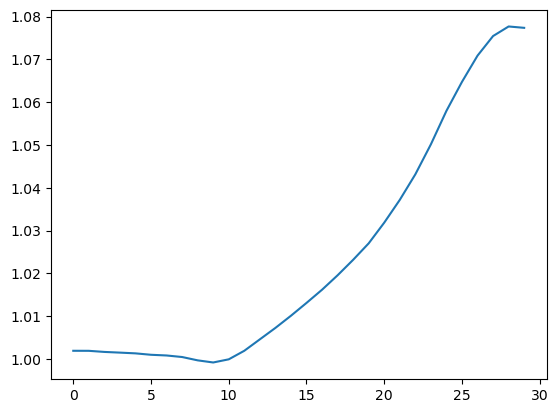

In [193]:
plt.plot(F_model_m/F_obs)

# Voy a comparar las diferencias medias (plot inferior)

error medio mio: 1.4394297212083647
error medio jens: 6.832879585839424


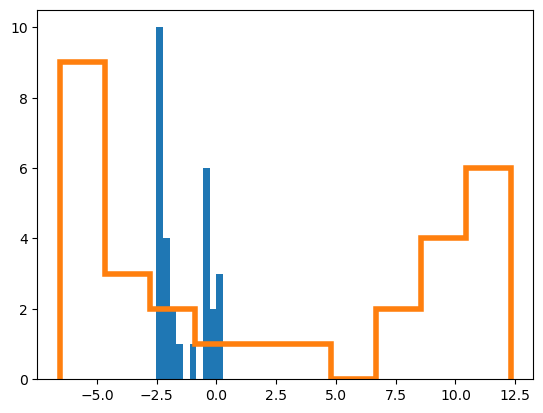

In [194]:
plt.hist(dif_model/dif_model_e)
plt.hist(dif_modelj/dif_modelj_e,histtype='step',lw=4)
print('error medio mio:',np.mean(abs(dif_model/dif_model_e)))
print('error medio jens:',np.mean(abs(dif_modelj/dif_modelj_e)))

In [195]:
48*42

2016